In [1]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 50.8 MB/s eta 0:00:00


# Import  libraries

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, log_loss, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from scipy.sparse import hstack
from rapidfuzz import process, fuzz
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from scipy.sparse import hstack, csr_matrix
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from tabulate import tabulate

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_path = '/content/drive/MyDrive/ADTA_Final_Project/Police_Bulk_Data_2014_20241027.csv'
police_data = pd.read_csv(file_path, low_memory=False)
police_data.head()


,AgencyORI,AgencyName,offenseservicenumber,offensedate,offensereporteddate,offensedescription,offensestarttime,offensestoptime,offensetimedispatched,offensebeat,...,offenseucr1,offenseucr2,offensemethodofoffense,offenseweather,offensefamilyviolence,offensegangacitivty,offensereportofficerbadge1,offensereportingofficerbadge2,offenserecorddate,offensestatus
0,TXDPD0000,Dallas Police - TX,0253449-A,9/29/2013 0:00,10/3/2013 0:00,INVESTIGATION OF BURGLARY,8:17:24,8:32:16,7:33,612,...,26000,NaN,APT ENTERED THROUGH UNLOCKED DOOR/PROPERTY TAKEN,NaN,N,N,7128,NaN,11/10/2013 0:45,Suspended
1,TXDPD0000,Dallas Police - TX,0264585-A,9/10/2013 0:00,10/15/2013 0:00,THEFT,12:23:46,12:56:08,12:20,622,...,6901,NaN,KNOWN SUSPECT REMOVED COMPLAINANT'S RINGS FROM...,VARIED,N,N,110,NaN,11/10/2013 0:45,Suspended
2,TXDPD0000,Dallas Police - TX,0255112-A,10/4/2013 0:00,10/5/2013 0:00,UNEXPLAINED DEATH/NATURALDEATH,0:15:38,0:26:07,23:34,433,...,40170,NaN,UNEXPLAINED DEATH,NaN,N,N,10368,9956,11/10/2013 0:45,Administratively Closed
3,TXDPD0000,Dallas Police - TX,0262565-A,10/13/2013 0:00,10/13/2013 0:00,CRIMINAL MISCHIEF,3:56:35,4:06:37,3:27,237,...,14081,NaN,SUSP BROKE WINDOW CAUSING DAMAGE,NaN,N,N,8996,9621,11/10/2013 0:45,Unfounded
4,TXDPD0000,Dallas Police - TX,0263038-A,10/13/2013 0:00,10/13/2013 0:00,RUNAWAY,18:39:33,20:27:44,18:16,221,...,29020,NaN,SUSP RANAWAY FROM LOCATION,NaN,N,N,8687,NaN,11/10/2013 0:45,Administratively Closed


In [6]:
# Identify numeric columns (integers and floats)
numeric_columns = police_data.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Identify categorical columns (objects)
categorical_columns = police_data.select_dtypes(include=["object"]).columns.tolist()

# Display the classification
print("Numeric Columns:")
print(numeric_columns)

print("\nCategorical Columns:")
print(categorical_columns)

Numeric Columns:
['offensereportingarea', 'offensesignal2', 'offensezip', 'offensepropertyattackcode']

Categorical Columns:
['AgencyORI', 'AgencyName', 'offenseservicenumber', 'offensedate', 'offensereporteddate', 'offensedescription', 'offensestarttime', 'offensestoptime', 'offensetimedispatched', 'offensebeat', 'offensewatch', 'offensesignal1', 'offensename', 'offenserace', 'offensegender', 'offenseage', 'offenseblock', 'offensedirection', 'offensestreet', 'offenseapartment', 'offensecity', 'offensestate', 'offensebusinessblock', 'offensebusinessdirection', 'offensebusinessstreet', 'offensebusinesscity', 'offensepremises', 'offensedateofoccurence1', 'offensetimeofoccurence1', 'offensedateofoccurence2', 'offensetimeofoccurence2', 'offenseucr1', 'offenseucr2', 'offensemethodofoffense', 'offenseweather', 'offensefamilyviolence', 'offensegangacitivty', 'offensereportofficerbadge1', 'offensereportingofficerbadge2', 'offenserecorddate', 'offensestatus']



# Data Cleaning

In [7]:
# Step 1: Check for missing values in each column
missing_data_summary = police_data.isnull().sum().reset_index()
missing_data_summary.columns = ["Column", "MissingCount"]
missing_data_summary["MissingPercentage"] = (
    missing_data_summary["MissingCount"] / len(police_data) * 100
)

# Display the summary of missing data
print("Missing Data Summary:")
print(missing_data_summary[missing_data_summary["MissingCount"] > 0])
print(police_data.shape)


Missing Data Summary:
                           Column  MissingCount  MissingPercentage
9                     offensebeat            22           0.027154
10           offensereportingarea            37           0.045669
12                 offensesignal1          3387           4.180552
13                 offensesignal2         80296          99.108840
14                    offensename             4           0.004937
15                    offenserace         16295          20.112814
16                  offensegender         16300          20.118986
17                     offenseage         16407          20.251055
19               offensedirection         62221          76.798983
21               offenseapartment         50268          62.045471
22                    offensecity           443           0.546792
23                   offensestate           591           0.729468
24                     offensezip          6884           8.496877
25           offensebusinessblock       

In [8]:
# Checking for missing values percentage per column
missing_percentage = (police_data.isnull().sum() / len(police_data)) * 100

# Dropping columns with more than 90% missing values
threshold = 90  # Percentage
columns_to_drop = missing_percentage[missing_percentage > threshold].index
print(f"\nColumns to drop (more than {threshold}% missing values): {columns_to_drop.tolist()}")
police_data = police_data.drop(columns=columns_to_drop)

# Displaying the shape of the cleaned dataset
print("\nShape of the dataset after cleaning:")
print(police_data.shape)


Columns to drop (more than 90% missing values): ['offensesignal2', 'offensebusinessblock', 'offensebusinessdirection', 'offensebusinessstreet', 'offensebusinesscity', 'offenseucr2', 'offenseweather']

Shape of the dataset after cleaning:
(81018, 38)


In [9]:
# Handle Missing Data
# - For Numeric Columns: Impute missing values using the median.
# - For Categorical Columns: Impute missing values using the mode (most frequent value).

numeric_columns = police_data.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_columns = police_data.select_dtypes(include=["object"]).columns.tolist()

# Impute missing values for numeric columns with the median
for col in numeric_columns:
    if col in police_data.columns:
        police_data[col] = police_data[col].fillna(police_data[col].median())

# Impute missing values for categorical columns with the mode
for col in categorical_columns:
    if col in police_data.columns:
        police_data[col] = police_data[col].fillna(police_data[col].mode()[0])

# Verify if missing data has been handled
missing_data_after = police_data.isnull().sum().sum()

if missing_data_after == 0:
    print("\nAll missing values have been successfully handled.")
else:
    print(f"\nThere are still {missing_data_after} missing values remaining.")

# Display the final status of missing data
print("\nFinal Missing Data Check:")
print(police_data.isnull().sum())

# Displaying the shape of the cleaned dataset
print("\nShape of the dataset after cleaning:")
print(police_data.shape)



All missing values have been successfully handled.

Final Missing Data Check:
AgencyORI                        0
AgencyName                       0
offenseservicenumber             0
offensedate                      0
offensereporteddate              0
offensedescription               0
offensestarttime                 0
offensestoptime                  0
offensetimedispatched            0
offensebeat                      0
offensereportingarea             0
offensewatch                     0
offensesignal1                   0
offensename                      0
offenserace                      0
offensegender                    0
offenseage                       0
offenseblock                     0
offensedirection                 0
offensestreet                    0
offenseapartment                 0
offensecity                      0
offensestate                     0
offensezip                       0
offensepropertyattackcode        0
offensepremises                  0
offensedate

In [10]:
# Outlier Detection using the IQR (Interquartile Range) Method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Identify numeric columns
numeric_columns = police_data.select_dtypes(include=["int64", "float64"]).columns.tolist()

In [11]:
#Detect and drop outliers
for col in numeric_columns:
    if col in police_data.columns:
        # Calculate IQR bounds
        lower_bound, upper_bound = detect_outliers_iqr(police_data, col)

        # Drop rows containing outliers
        police_data = police_data[(police_data[col] >= lower_bound) & (police_data[col] <= upper_bound)]

#  Verify if outliers have been removed
outliers_after_dropping = {
    col: len(police_data[(police_data[col] < detect_outliers_iqr(police_data, col)[0]) |
                        (police_data[col] > detect_outliers_iqr(police_data, col)[1])])
    for col in numeric_columns
}

# Display the final check for outliers and the updated dataset size
remaining_rows = len(police_data)
print("Outliers After Dropping:", outliers_after_dropping)
print(f"Updated Dataset Size: {remaining_rows} rows")

# Displaying the shape of the cleaned dataset
print("\nShape of the dataset after cleaning:")
print(police_data.shape)
#  Save the cleaned dataset
#police_data.to_csv("cleaned_arrests_df.csv", index=False)

Outliers After Dropping: {'offensereportingarea': 0, 'offensezip': 222, 'offensepropertyattackcode': 0}
Updated Dataset Size: 66280 rows

Shape of the dataset after cleaning:
(66280, 38)


Formatting Date

In [12]:
from tabulate import tabulate

# Convert the date columns to datetime objects
police_data['offensedate'] = pd.to_datetime(police_data['offensedate'], errors='coerce')
police_data['offensereporteddate'] = pd.to_datetime(police_data['offensereporteddate'], errors='coerce')

# Clean and parse the "offensestarttime" column to extract the hour
if 'offensestarttime' in police_data.columns:
    police_data['offensestarttime'] = police_data['offensestarttime'].astype(str).str.strip()
    police_data['offensestarttime'] = pd.to_datetime(police_data['offensestarttime'], format='%H:%M:%S', errors='coerce')
    police_data['offense_hour'] = police_data['offensestarttime'].dt.hour
else:
    police_data['offense_hour'] = None

# Extract useful features from the "offensedate" column
police_data['offense_month'] = police_data['offensedate'].dt.month
police_data['offense_day_of_week'] = police_data['offensedate'].dt.day_name()

# Display Extracted Features
print("\nExtracted Features (First 5 Rows):")
print(tabulate(police_data[['offensedate', 'offensereporteddate', 'offense_month',
                            'offense_day_of_week', 'offense_hour']].head(),
               headers=['Offense Date', 'Reported Date', 'Month', 'Day of Week', 'Hour'],
               tablefmt='pretty'))

# Check for remaining null values
missing_values = police_data[['offense_month', 'offense_day_of_week', 'offense_hour']].isnull().sum()
print("\nMissing Values in Extracted Features:")
print(tabulate(missing_values.reset_index(), headers=["Feature", "Missing Values"], tablefmt="pretty"))

# Display the shape of the updated dataset
print("\nShape of the Updated Dataset:")
print(tabulate([["Rows", police_data.shape[0]], ["Columns", police_data.shape[1]]],
               headers=["Metric", "Count"], tablefmt="pretty"))



Extracted Features (First 5 Rows):
+---+---------------------+---------------------+-------+-------------+------+
|   |    Offense Date     |    Reported Date    | Month | Day of Week | Hour |
+---+---------------------+---------------------+-------+-------------+------+
| 1 | 2013-09-10 00:00:00 | 2013-10-15 00:00:00 |   9   |   Tuesday   |  12  |
| 2 | 2013-10-04 00:00:00 | 2013-10-05 00:00:00 |  10   |   Friday    |  0   |
| 3 | 2013-10-13 00:00:00 | 2013-10-13 00:00:00 |  10   |   Sunday    |  3   |
| 4 | 2013-10-13 00:00:00 | 2013-10-13 00:00:00 |  10   |   Sunday    |  18  |
| 5 | 2013-10-04 00:00:00 | 2013-10-08 00:00:00 |  10   |   Friday    |  9   |
+---+---------------------+---------------------+-------+-------------+------+

Missing Values in Extracted Features:
+---+---------------------+----------------+
|   |       Feature       | Missing Values |
+---+---------------------+----------------+
| 0 |    offense_month    |       0        |
| 1 | offense_day_of_week |       

# Exploratory Data Analysis (EDA)

In [13]:
# Analyze High-Crime Areas (Group by `offensebeat` and count occurrences)
high_crime_areas = police_data['offensebeat'].value_counts().head(10)

# Analyze Temporal Patterns (Day of the Week and Hour of the Day)
crimes_by_day = police_data['offense_day_of_week'].value_counts()
crimes_by_hour = police_data['offense_hour'].value_counts().sort_index()

# Analyze Crime Types (Group by `offensedescription` and count occurrences)
common_crime_types = police_data['offensedescription'].value_counts().head(10)

# Prepare High-Crime Areas Data
print("\nTop 10 High-Crime Areas:")
print(tabulate(high_crime_areas.reset_index(), headers=["Offense Beat", "Incidents"], tablefmt="pretty"))

# Prepare Crimes by Day of the Week
print("\nCrimes by Day of the Week:")
print(tabulate(crimes_by_day.reset_index(), headers=["Day of the Week", "Incidents"], tablefmt="pretty"))

# Prepare Crimes by Hour of the Day
print("\nCrimes by Hour of the Day:")
print(tabulate(crimes_by_hour.reset_index(), headers=["Hour of the Day", "Incidents"], tablefmt="pretty"))

# Prepare Common Crime Types Data
print("\nTop 10 Common Crime Types:")
print(tabulate(common_crime_types.reset_index(), headers=["Crime Type", "Incidents"], tablefmt="pretty"))




Top 10 High-Crime Areas:
+---+--------------+-----------+
|   | Offense Beat | Incidents |
+---+--------------+-----------+
| 0 |     318      |    895    |
| 1 |     151      |    692    |
| 2 |     252      |    647    |
| 3 |     416      |    624    |
| 4 |     744      |    616    |
| 5 |     257      |    565    |
| 6 |     216      |    538    |
| 7 |     233      |    532    |
| 8 |     741      |    528    |
| 9 |     644      |    509    |
+---+--------------+-----------+

Crimes by Day of the Week:
+---+-----------------+-----------+
|   | Day of the Week | Incidents |
+---+-----------------+-----------+
| 0 |     Friday      |   10407   |
| 1 |    Saturday     |   9729    |
| 2 |    Thursday     |   9509    |
| 3 |    Wednesday    |   9292    |
| 4 |     Tuesday     |   9271    |
| 5 |     Monday      |   9165    |
| 6 |     Sunday      |   8907    |
+---+-----------------+-----------+

Crimes by Hour of the Day:
+----+-----------------+-----------+
|    | Hour of the Day 

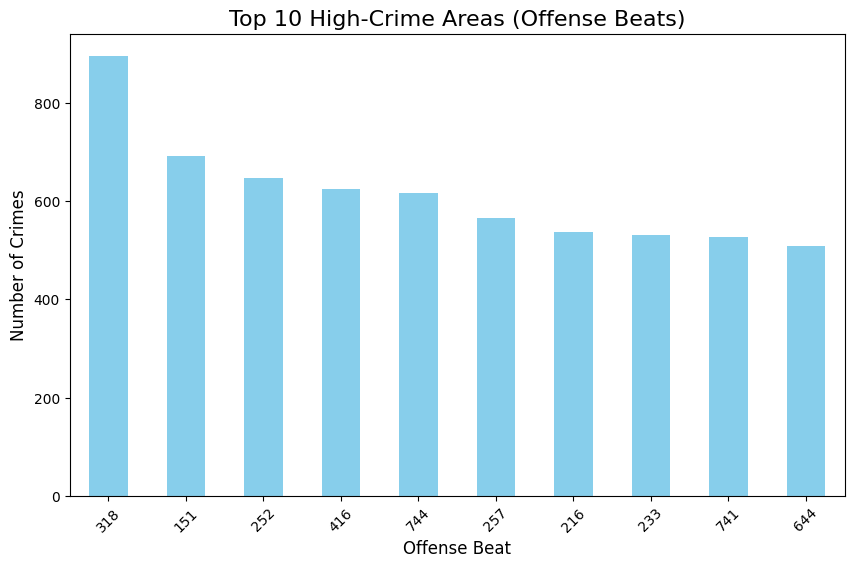

In [14]:
# Visualization 1: High-Crime Areas (Top Offense Beats)
plt.figure(figsize=(10, 6))
high_crime_areas.plot(kind='bar', color='skyblue')
plt.title('Top 10 High-Crime Areas (Offense Beats)', fontsize=16)
plt.xlabel('Offense Beat', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.xticks(rotation=45)
plt.show()


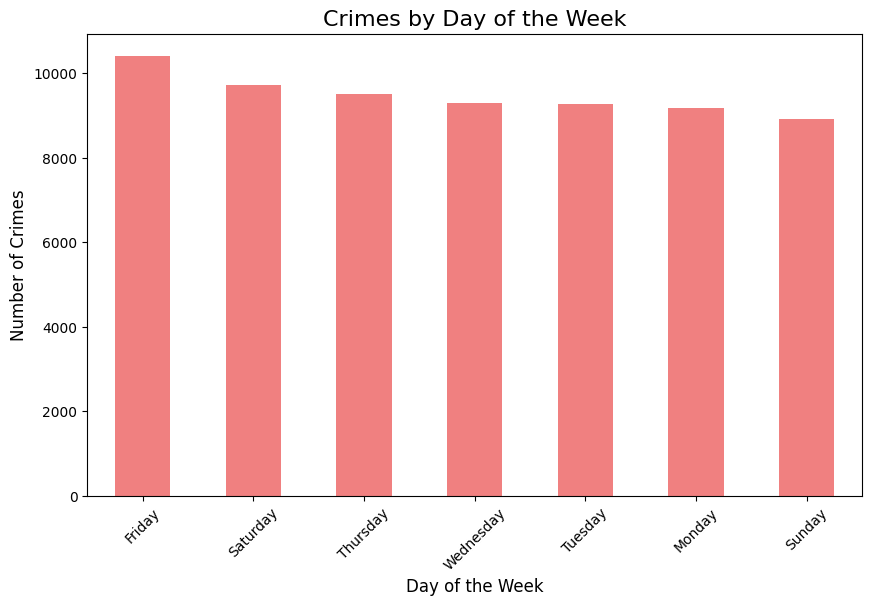

In [15]:
# Visualization 2: Crimes by Day of the Week
plt.figure(figsize=(10, 6))
crimes_by_day.plot(kind='bar', color='lightcoral')
plt.title('Crimes by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.xticks(rotation=45)
plt.show()

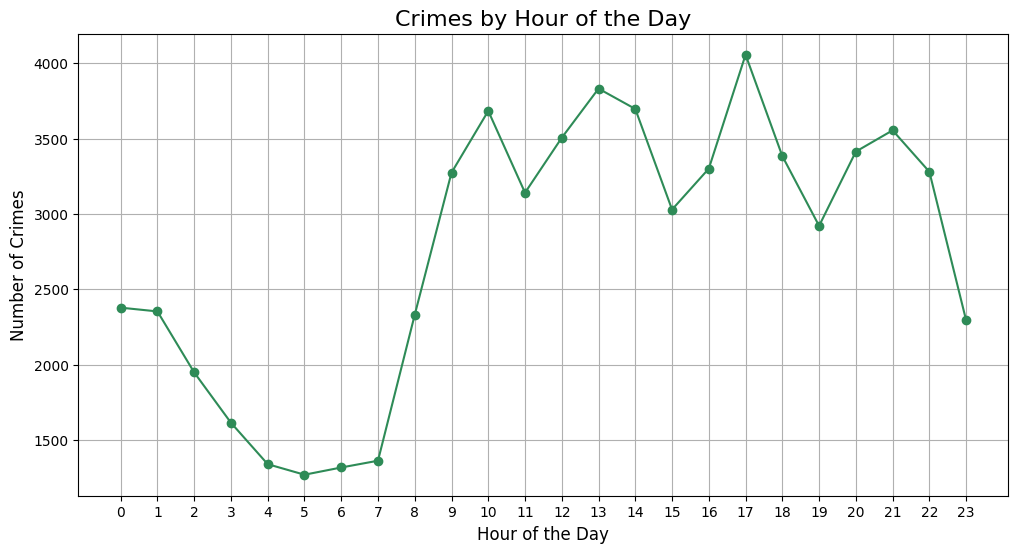

In [16]:
# Visualization 3: Crimes by Hour of the Day
plt.figure(figsize=(12, 6))
crimes_by_hour.plot(kind='line', marker='o', color='seagreen')
plt.title('Crimes by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

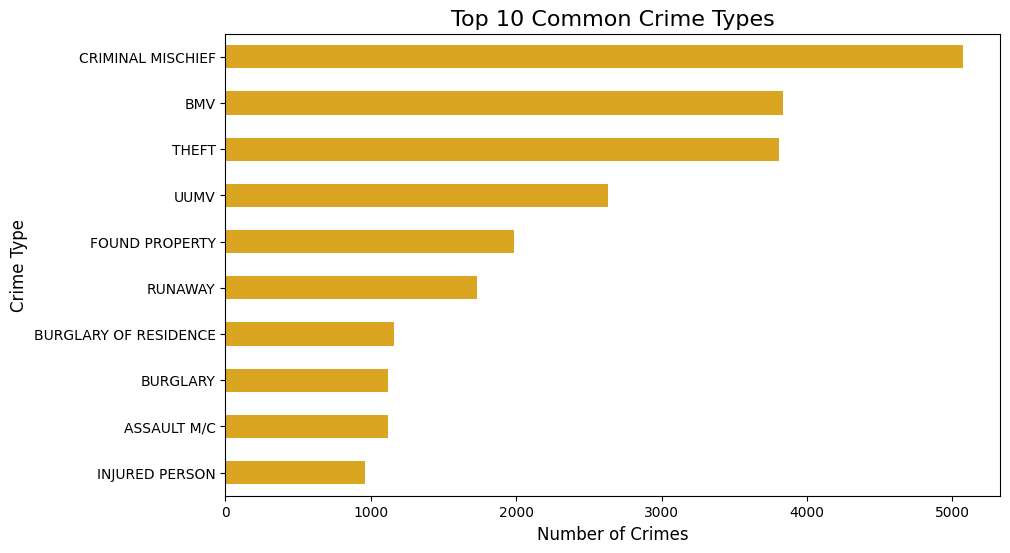

In [17]:
# Visualization 4: Common Crime Types (Top 10)
plt.figure(figsize=(10, 6))
common_crime_types.plot(kind='barh', color='goldenrod')
plt.title('Top 10 Common Crime Types', fontsize=16)
plt.xlabel('Number of Crimes', fontsize=12)
plt.ylabel('Crime Type', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

Combine Spatial and Temporal Patterns

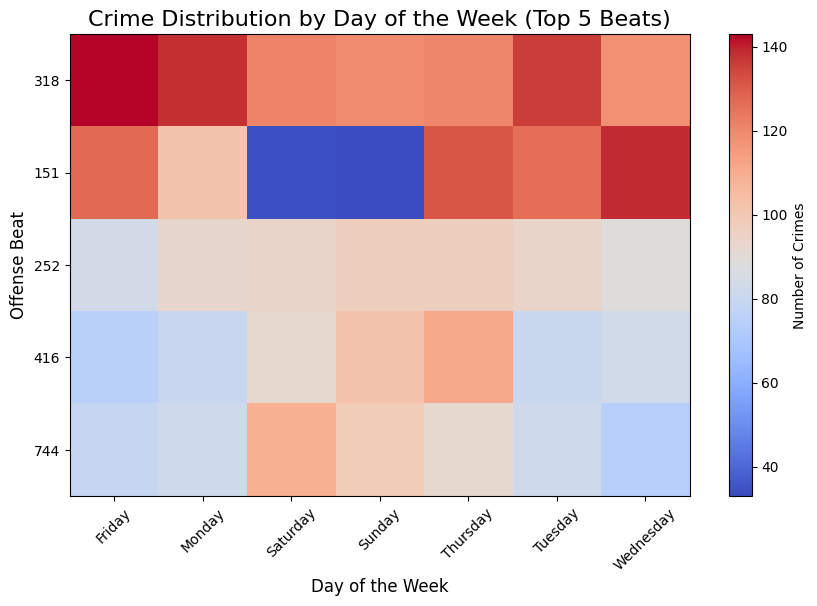

In [18]:
# Step 1: Group data by offensebeat and day of the week
beat_day_analysis = police_data.groupby(['offensebeat', 'offense_day_of_week']).size().unstack(fill_value=0)

# Step 2: Group data by offensebeat and hour of the day
beat_hour_analysis = police_data.groupby(['offensebeat', 'offense_hour']).size().unstack(fill_value=0)

# Step 3: Visualize the top 5 high-crime beats by day and hour
top_beats = high_crime_areas.index[:5]

# Visualization: Heatmap for crimes by day of the week for top beats
plt.figure(figsize=(10, 6))
plt.imshow(beat_day_analysis.loc[top_beats], cmap='coolwarm', aspect='auto')
plt.title('Crime Distribution by Day of the Week (Top 5 Beats)', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Offense Beat', fontsize=12)
plt.xticks(ticks=range(len(beat_day_analysis.columns)), labels=beat_day_analysis.columns, rotation=45)
plt.yticks(ticks=range(len(top_beats)), labels=top_beats)
plt.colorbar(label='Number of Crimes')
plt.show()

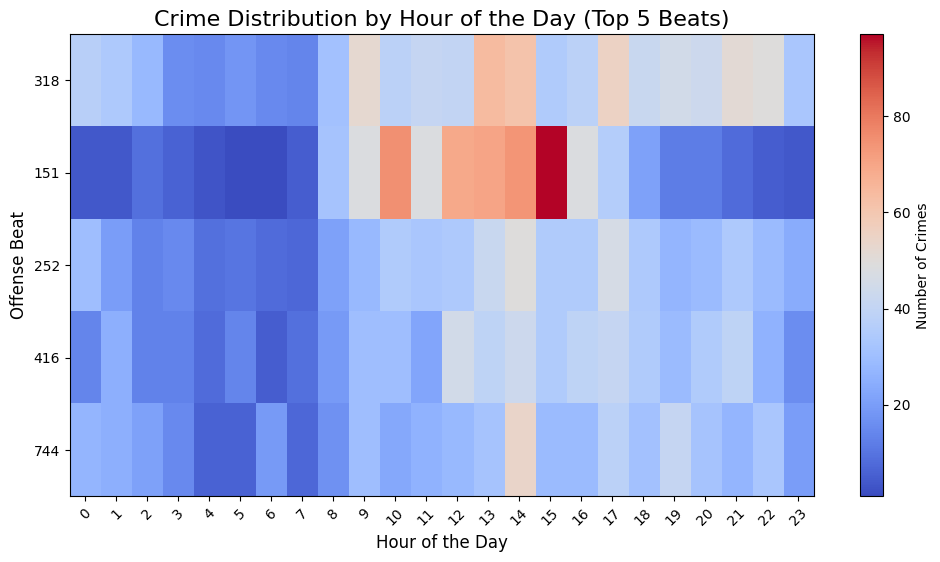

In [19]:
# Visualization: Heatmap for crimes by hour of the day for top beats
plt.figure(figsize=(12, 6))
plt.imshow(beat_hour_analysis.loc[top_beats], cmap='coolwarm', aspect='auto')
plt.title('Crime Distribution by Hour of the Day (Top 5 Beats)', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Offense Beat', fontsize=12)
plt.xticks(ticks=range(24), labels=range(24), rotation=45)
plt.yticks(ticks=range(len(top_beats)), labels=top_beats)
plt.colorbar(label='Number of Crimes')
plt.show()

In [20]:
# Identify numeric columns (integers and floats)
numeric_columns = police_data.select_dtypes(include=["int64", "int32", "float64"]).columns.tolist()

# Identify categorical columns (objects)
categorical_columns = police_data.select_dtypes(include=["object"]).columns.tolist()

# Identify datetime columns
datetime_columns = police_data.select_dtypes(include=["datetime64"]).columns.tolist()

# Display the classification
print("Numeric Columns:")
print(numeric_columns)

print("\nCategorical Columns:")
print(categorical_columns)

print("\nDatetime Columns:")
print(datetime_columns)

Numeric Columns:
['offensereportingarea', 'offensezip', 'offensepropertyattackcode', 'offense_hour', 'offense_month']

Categorical Columns:
['AgencyORI', 'AgencyName', 'offenseservicenumber', 'offensedescription', 'offensestoptime', 'offensetimedispatched', 'offensebeat', 'offensewatch', 'offensesignal1', 'offensename', 'offenserace', 'offensegender', 'offenseage', 'offenseblock', 'offensedirection', 'offensestreet', 'offenseapartment', 'offensecity', 'offensestate', 'offensepremises', 'offensedateofoccurence1', 'offensetimeofoccurence1', 'offensedateofoccurence2', 'offensetimeofoccurence2', 'offenseucr1', 'offensemethodofoffense', 'offensefamilyviolence', 'offensegangacitivty', 'offensereportofficerbadge1', 'offensereportingofficerbadge2', 'offenserecorddate', 'offensestatus', 'offense_day_of_week']

Datetime Columns:
['offensedate', 'offensereporteddate', 'offensestarttime']


# Predictive Modeling

In [21]:

unique_count = police_data['offensedescription'].nunique()
print(f"Unique count: {unique_count}")

Unique count: 7892


## Base Model (offensestatus)

In [ ]:
# Step 1: Create a copy of the cleaned data
cleaned_data = police_data.copy()

# Step 2: Select features and target
target_variable = 'offensestatus'
X = cleaned_data.drop(columns=[target_variable])
y = cleaned_data[target_variable]

# Step 3: Process datetime columns
datetime_columns = X.select_dtypes(include=['datetime64', 'object']).columns
for col in datetime_columns:
    try:
        X.drop(columns=[col], inplace=True)  # Drop the original column
    except Exception as e:
        print(f"Skipping {col}: {e}")

# Step 4: Encode categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns
label_encoders = {col: LabelEncoder() for col in categorical_cols}
for col in categorical_cols:
    X[col] = label_encoders[col].fit_transform(X[col].astype(str))

# Encode the target variable
label_encoder_target = LabelEncoder()
y = label_encoder_target.fit_transform(y)

# Step 5: Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Step 6: Train a Random Forest model with class weight handling
rf_base = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100, max_depth=None)
rf_base.fit(X_train, y_train)

# Step 7: Make predictions
y_pred_base = rf_base.predict(X_test)

# Step 8: Evaluate the model
base_accuracy = accuracy_score(y_test, y_pred_base)
base_report = classification_report(y_test, y_pred_base, target_names=label_encoder_target.classes_, zero_division=1)
base_confusion_matrix = confusion_matrix(y_test, y_pred_base)

# Output results
print("\nBase Accuracy:", base_accuracy)
print("\nClassification Report:\n", base_report)
print("\nConfusion Matrix:\n", base_confusion_matrix)

# Step 9: Check class distributions for analysis
print("\nClass Distribution in y_train:", dict(pd.Series(y_train).value_counts()))
print("Class Distribution in y_test:", dict(pd.Series(y_test).value_counts()))


Base Accuracy: 0.6673204586602294

Classification Report:
                                precision    recall  f1-score   support

      Administratively Closed       0.20      0.09      0.13       973
                            C       1.00      0.00      0.00         3
            Cleared by Arrest       0.40      0.22      0.29      2654
Cleared by Exceptional Arrest       0.17      0.06      0.09      1280
                         Open       0.14      0.05      0.07       808
                    Suspended       0.73      0.91      0.81     13747
        System.Xml.XmlElement       1.00      0.00      0.00         2
                    Unfounded       0.12      0.03      0.05       417

                     accuracy                           0.67     19884
                    macro avg       0.47      0.17      0.18     19884
                 weighted avg       0.59      0.67      0.61     19884


Confusion Matrix:
 [[   90     0    80    41    27   728     0     7]
 [    0     0 

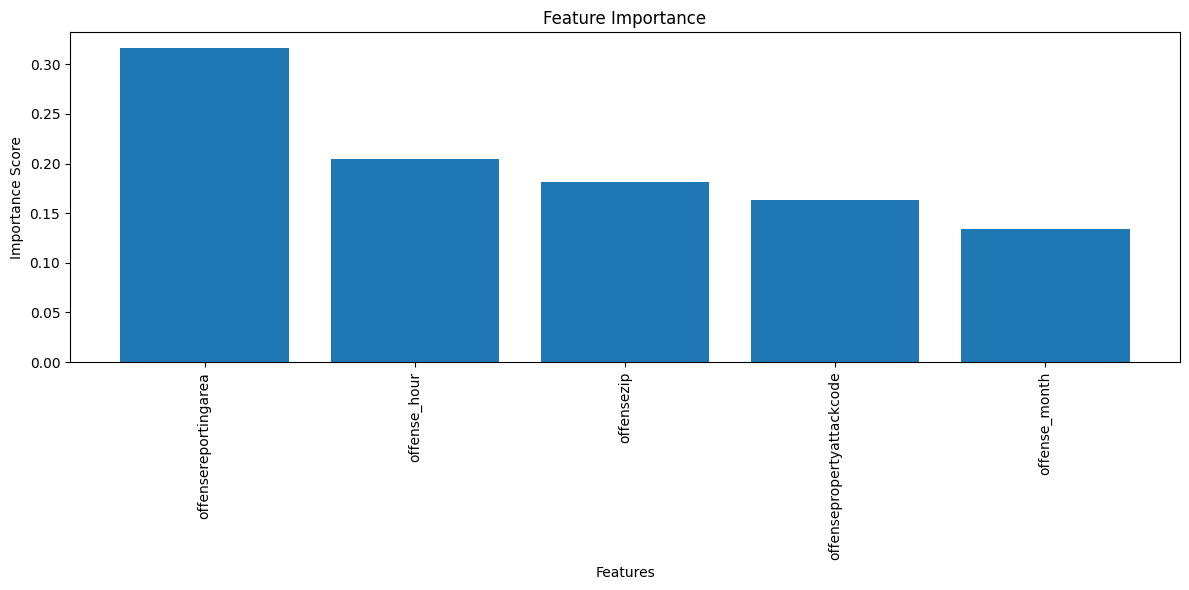

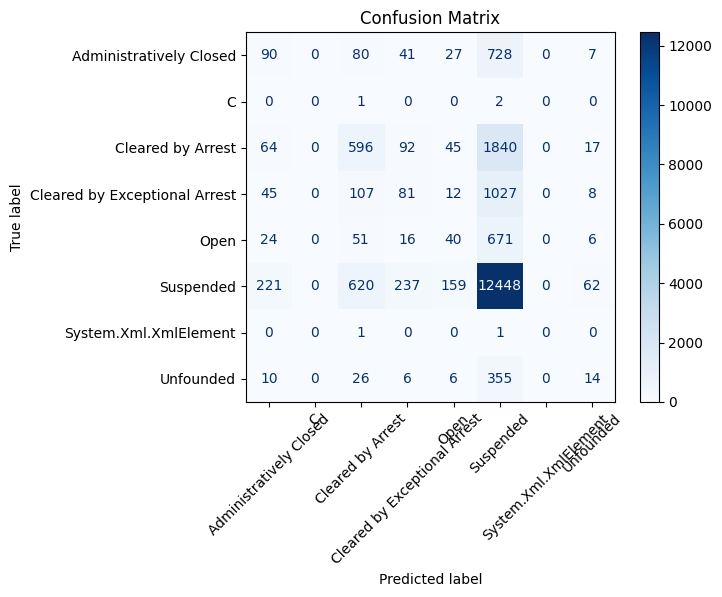

ROC curve is applicable only for binary classification problems.


In [ ]:
# Feature Importance Plot
feature_importances = rf_base.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]  # Sort by importance descending
sorted_feature_names = X.columns[sorted_indices]

plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(feature_importances)), sorted_feature_names, rotation=90)
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

# Confusion Matrix Plot
disp = ConfusionMatrixDisplay(confusion_matrix=base_confusion_matrix, display_labels=label_encoder_target.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Check if the problem is binary classification for ROC curve
if len(label_encoder_target.classes_) == 2:
    # Compute ROC Curve
    y_proba = rf_base.predict_proba(X_test)[:, 1]  # Probability for the positive class
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
else:
    print("ROC curve is applicable only for binary classification problems.")


## Improved Model with SMOTE to address the class imbalance

In [ ]:
# Copy the cleaned data
cleaned_data = police_data.copy()

# Select features and target
target_variable = 'offensestatus'
X = cleaned_data.drop(columns=[target_variable])
y = cleaned_data[target_variable]

# Feature engineering: Process datetime columns
datetime_columns = X.select_dtypes(include=['datetime64', 'object']).columns
for col in datetime_columns:
    try:
        X.drop(columns=[col], inplace=True)  # Drop the original column
    except Exception as e:
        print(f"Skipping {col}: {e}")

# Ensure categorical columns are encoded
categorical_cols = X.select_dtypes(include=['object']).columns
label_encoders = {col: LabelEncoder() for col in categorical_cols}
for col in categorical_cols:
    X[col] = label_encoders[col].fit_transform(X[col].astype(str))

# Handle missing values with imputation
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = imputer.fit_transform(X)  # Impute missing values

# Convert back to a DataFrame with correct column names
X = pd.DataFrame(X_imputed, columns=X.columns)

# Encode the target variable
label_encoder_target = LabelEncoder()
y = label_encoder_target.fit_transform(y)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Reset index to ensure consistency
X.reset_index(drop=True, inplace=True)
y = pd.Series(y).reset_index(drop=True)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train XGBoost classifier with updated parameters for GPU
xgb = XGBClassifier(
    tree_method='hist',  # Use histogram-based tree method
    device='cuda',       # Set GPU as the training device
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    random_state=42
)
xgb.fit(X_train, y_train)

# Make predictions
y_pred_best = xgb.predict(X_test)

# Evaluate the model
best_accuracy = accuracy_score(y_test, y_pred_best)
best_report = classification_report(y_test, y_pred_best, target_names=label_encoder_target.classes_)
best_confusion_matrix = confusion_matrix(y_test, y_pred_best)

# Output results
print("Improved Accuracy with GPU:", best_accuracy)
print("\nClassification Report:\n", best_report)
print("\nConfusion Matrix:\n", best_confusion_matrix)


Improved Accuracy with GPU: 0.8366370844547901

Classification Report:
                                precision    recall  f1-score   support

      Administratively Closed       0.75      0.80      0.77     13747
                            C       1.00      1.00      1.00     13747
            Cleared by Arrest       0.81      0.57      0.67     13747
Cleared by Exceptional Arrest       0.79      0.71      0.75     13747
                         Open       0.80      0.83      0.82     13747
                    Suspended       0.73      0.91      0.81     13747
        System.Xml.XmlElement       1.00      1.00      1.00     13747
                    Unfounded       0.83      0.88      0.85     13747

                     accuracy                           0.84    109976
                    macro avg       0.84      0.84      0.83    109976
                 weighted avg       0.84      0.84      0.83    109976


Confusion Matrix:
 [[10958     6   351   549   568   743     1   571]
 [

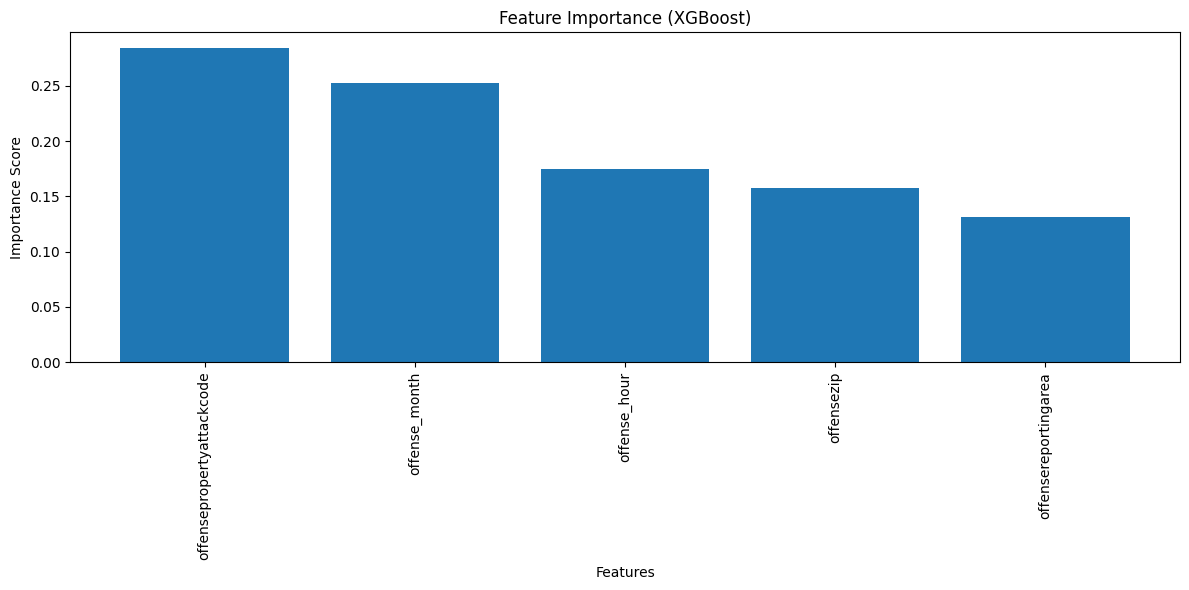

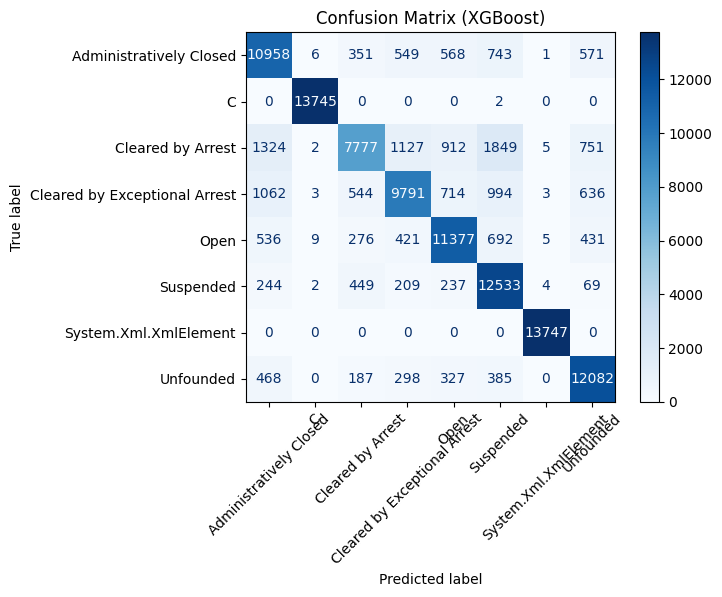

ROC and Precision-Recall curves are applicable only for binary classification problems.


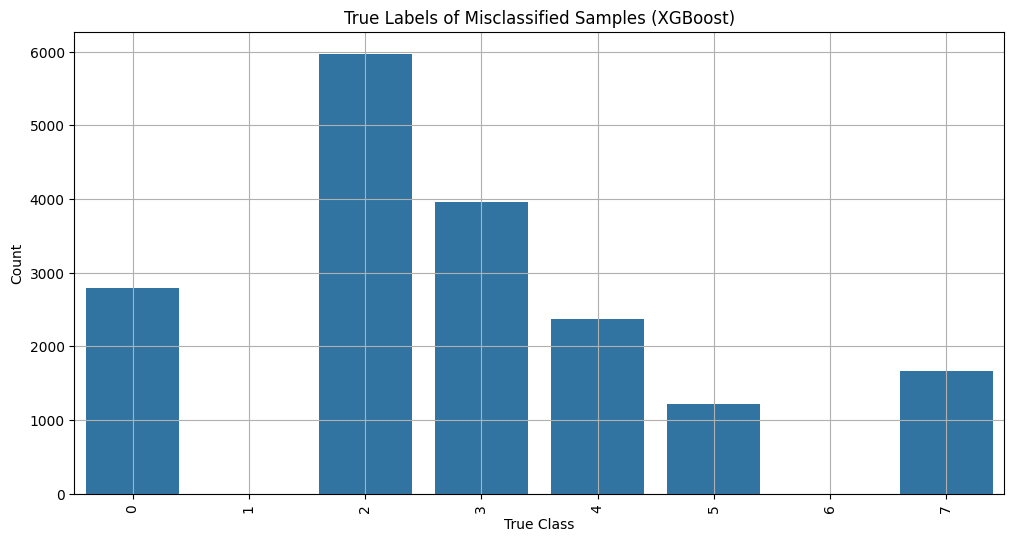

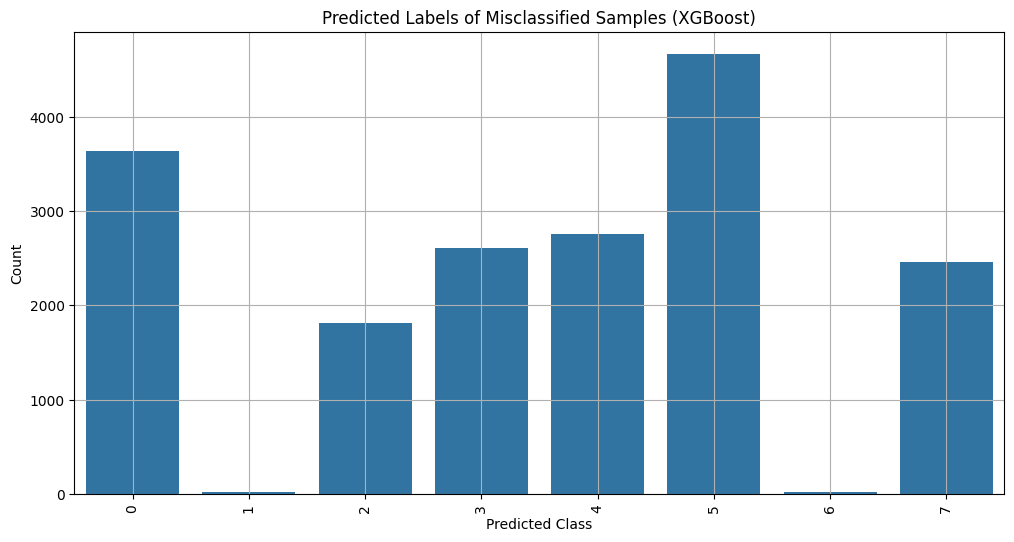

In [ ]:

# Feature Importance Plot
feature_importances = xgb.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]  # Sort by importance descending
sorted_feature_names = X.columns[sorted_indices]

plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(feature_importances)), sorted_feature_names, rotation=90)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

# Confusion Matrix Plot
disp = ConfusionMatrixDisplay(confusion_matrix=best_confusion_matrix, display_labels=label_encoder_target.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (XGBoost)")
plt.show()

# Check if the problem is binary classification for ROC curve
if len(label_encoder_target.classes_) == 2:
    # Compute ROC Curve
    y_proba = xgb.predict_proba(X_test)[:, 1]  # Probability for the positive class
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title("ROC Curve (XGBoost)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='purple', lw=2, label="Precision-Recall curve")
    plt.title("Precision-Recall Curve (XGBoost)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()

else:
    print("ROC and Precision-Recall curves are applicable only for binary classification problems.")

# Distribution of Predicted Probabilities
if len(label_encoder_target.classes_) == 2:
    plt.figure(figsize=(8, 6))
    sns.histplot(y_proba, bins=50, kde=True, color='blue', alpha=0.7)
    plt.title("Distribution of Predicted Probabilities (XGBoost)")
    plt.xlabel("Predicted Probability of Positive Class")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

# Error Analysis - Misclassified Samples
misclassified_indices = y_test != y_pred_best
X_misclassified = X_test[misclassified_indices]
y_misclassified_true = y_test[misclassified_indices]
y_misclassified_pred = y_pred_best[misclassified_indices]

plt.figure(figsize=(12, 6))
sns.countplot(x=y_misclassified_true, order=np.sort(np.unique(y_test)))
plt.title("True Labels of Misclassified Samples (XGBoost)")
plt.xlabel("True Class")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x=y_misclassified_pred, order=np.sort(np.unique(y_pred_best)))
plt.title("Predicted Labels of Misclassified Samples (XGBoost)")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.grid()
plt.show()


## Base Model - Logistic Regression model (offensedescription)



In [ ]:
# Downsample the DataFrame to reduce memory usage
police_data_downsampled = police_data.sample(frac=0.1, random_state=42)

# Get unique values in 'offensedescription'
unique_offenses = police_data_downsampled['offensedescription'].unique()

# Define a function to perform fuzzy matching and reduce unique targets
def reduce_unique_targets(offenses, threshold=80):
    reduced_offenses = {}
    for offense in offenses:
        match = process.extractOne(offense, reduced_offenses.keys(), scorer=fuzz.token_sort_ratio)
        if match and match[1] >= threshold:
            reduced_offenses[match[0]].append(offense)
        else:
            reduced_offenses[offense] = [offense]
    return reduced_offenses

# Reduce unique targets in 'offensedescription'
reduced_offenses = reduce_unique_targets(unique_offenses)

# Map original offenses to reduced offenses
def map_to_reduced_offense(offense, reduced_offenses):
    for key, values in reduced_offenses.items():
        if offense in values:
            return key
    return offense

police_data_downsampled['reduced_offensedescription'] = police_data_downsampled['offensedescription'].apply(
    lambda x: map_to_reduced_offense(x, reduced_offenses)
)

# Define the correct categorical and numerical columns
categorical_cols = [
    'AgencyORI', 'AgencyName', 'offenseservicenumber', 'offensedescription',
    'offensestarttime', 'offensestoptime', 'offensetimedispatched',
    'offensebeat', 'offensewatch', 'offensesignal1', 'offensename',
    'offenserace', 'offensegender', 'offenseage', 'offenseblock',
    'offensedirection', 'offensestreet', 'offenseapartment', 'offensecity',
    'offensestate', 'offensepremises', 'offensedateofoccurence1',
    'offensetimeofoccurence1', 'offensedateofoccurence2',
    'offensetimeofoccurence2', 'offenseucr1', 'offensemethodofoffense',
    'offensefamilyviolence', 'offensegangacitivty',
    'offensereportofficerbadge1', 'offensereportingofficerbadge2',
    'offenserecorddate', 'offensestatus', 'offense_day_of_week'
]

numerical_cols = [
    'offensereportingarea', 'offensezip', 'offensepropertyattackcode',
    'offense_month', 'offense_hour'
]

# Combine rare categories in categorical columns
def combine_rare_categories(series, threshold=10):
    counts = series.value_counts()
    rare_categories = counts[counts < threshold].index
    return series.apply(lambda x: 'Other' if x in rare_categories else x)

for col in categorical_cols:
    police_data_downsampled[col] = combine_rare_categories(police_data_downsampled[col])

# Ensure all categorical columns are strings
police_data_downsampled[categorical_cols] = police_data_downsampled[categorical_cols].astype(str)

# One-hot encode categorical columns
encoder = OneHotEncoder()
X_categorical = encoder.fit_transform(police_data_downsampled[categorical_cols])

# Combine numerical and encoded categorical features
X_numerical = police_data_downsampled[numerical_cols].values
X = hstack([X_numerical, X_categorical])

# Encode the target variable with reduced offenses
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(police_data_downsampled['reduced_offensedescription'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature selection with Random Forest
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
selector = SelectFromModel(rf, prefit=True)
X_train_reduced = selector.transform(X_train)
X_test_reduced = selector.transform(X_test)

# Train a lightweight Logistic Regression model
lr = LogisticRegression(max_iter=1000, n_jobs=-1)
lr.fit(X_train_reduced, y_train)

# Make predictions
y_pred = lr.predict(X_test_reduced)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")

# Generate the classification report as a dictionary
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

# Convert the report to a DataFrame for better manipulation
report_df = pd.DataFrame(report_dict).transpose()

# Sort by 'support' column to get the top 10 classes
top_10_report = report_df.sort_values(by='support', ascending=False).head(10)

# Display the top 10 classes' classification report
print(top_10_report)


Accuracy: 0.09803921568627451
Classification Report:
              precision    recall  f1-score  support
weighted avg   0.019721  0.098039  0.030058   1326.0
macro avg      0.001449  0.008595  0.002217   1326.0
206            0.092683  0.513514  0.157025    111.0
134            0.108818  0.682353  0.187702     85.0
606            0.000000  0.000000  0.000000     68.0
525            0.090909  0.064516  0.075472     62.0
82             0.000000  0.000000  0.000000     62.0
276            0.000000  0.000000  0.000000     41.0
486            0.000000  0.000000  0.000000     38.0
115            0.000000  0.000000  0.000000     36.0


## Random Forest Model (offensedescription)

In [ ]:
# Downsample the DataFrame to reduce memory usage
police_data_downsampled = police_data.sample(frac=0.1, random_state=42)

# Get unique values in 'offensedescription'
unique_offenses = police_data_downsampled['offensedescription'].unique()

# Define a function to perform fuzzy matching and reduce unique targets
def reduce_unique_targets(offenses, threshold=80):
    reduced_offenses = {}
    for offense in offenses:
        match = process.extractOne(offense, reduced_offenses.keys(), scorer=fuzz.token_sort_ratio)
        if match and match[1] >= threshold:
            reduced_offenses[match[0]].append(offense)
        else:
            reduced_offenses[offense] = [offense]
    return reduced_offenses

# Reduce unique targets in 'offensedescription'
reduced_offenses = reduce_unique_targets(unique_offenses)

# Map original offenses to reduced offenses
def map_to_reduced_offense(offense, reduced_offenses):
    for key, values in reduced_offenses.items():
        if offense in values:
            return key
    return offense

police_data_downsampled['reduced_offensedescription'] = police_data_downsampled['offensedescription'].apply(
    lambda x: map_to_reduced_offense(x, reduced_offenses)
)

# Define the correct categorical and numerical columns
categorical_cols = [
    'AgencyORI', 'AgencyName', 'offenseservicenumber', 'offensedescription',
    'offensestarttime', 'offensestoptime', 'offensetimedispatched',
    'offensebeat', 'offensewatch', 'offensesignal1', 'offensename',
    'offenserace', 'offensegender', 'offenseage', 'offenseblock',
    'offensedirection', 'offensestreet', 'offenseapartment', 'offensecity',
    'offensestate', 'offensepremises', 'offensedateofoccurence1',
    'offensetimeofoccurence1', 'offensedateofoccurence2',
    'offensetimeofoccurence2', 'offenseucr1', 'offensemethodofoffense',
    'offensefamilyviolence', 'offensegangacitivty',
    'offensereportofficerbadge1', 'offensereportingofficerbadge2',
    'offenserecorddate', 'offensestatus', 'offense_day_of_week'
]

numerical_cols = [
    'offensereportingarea', 'offensezip', 'offensepropertyattackcode',
    'offense_month', 'offense_hour'
]

# Ensure all categorical columns are strings
police_data_downsampled[categorical_cols] = police_data_downsampled[categorical_cols].astype(str)

# One-hot encode categorical columns
encoder = OneHotEncoder()
X_categorical = encoder.fit_transform(police_data_downsampled[categorical_cols])

# Combine numerical and encoded categorical features
X_numerical = police_data_downsampled[numerical_cols].values
X = hstack([X_numerical, X_categorical])

# Encode the target variable with reduced offenses
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(police_data_downsampled['reduced_offensedescription'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")

# Generate the classification report as a dictionary
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

# Convert the report to a DataFrame for better manipulation
report_df = pd.DataFrame(report_dict).transpose()

# Sort by 'support' column to get the top 10 classes
top_10_report = report_df.sort_values(by='support', ascending=False).head(10)

# Display the top 10 classes' classification report
print(top_10_report)

Accuracy: 0.6870286576168929
Classification Report:
              precision    recall  f1-score  support
weighted avg   0.612563  0.687029  0.611646   1326.0
macro avg      0.234065  0.216606  0.207546   1326.0
206            0.800000  0.972973  0.878049    111.0
134            0.653846  1.000000  0.790698     85.0
606            0.829268  1.000000  0.906667     68.0
525            0.688889  1.000000  0.815789     62.0
82             0.518182  0.919355  0.662791     62.0
276            0.594203  1.000000  0.745455     41.0
486            0.844444  1.000000  0.915663     38.0
115            0.387097  1.000000  0.558140     36.0


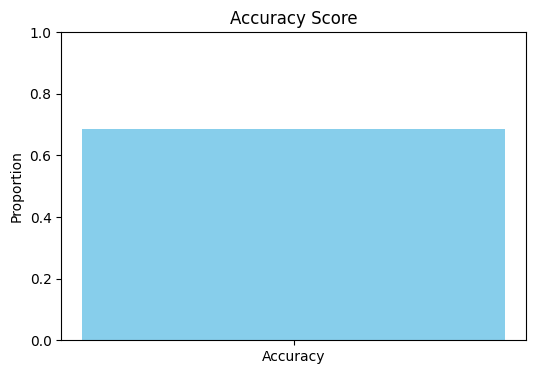

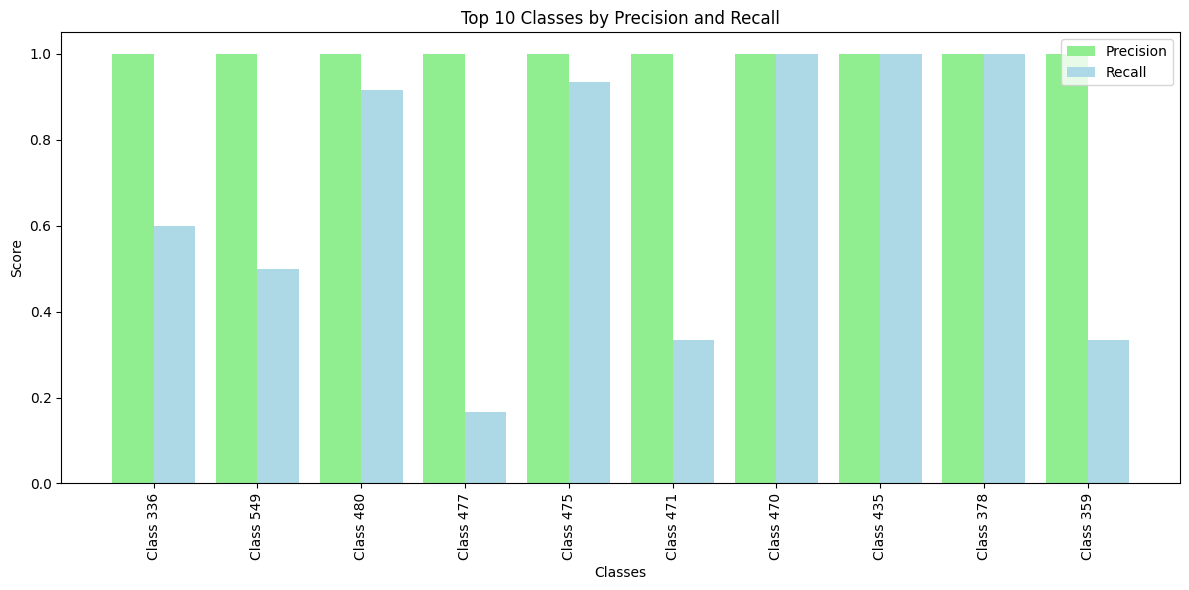

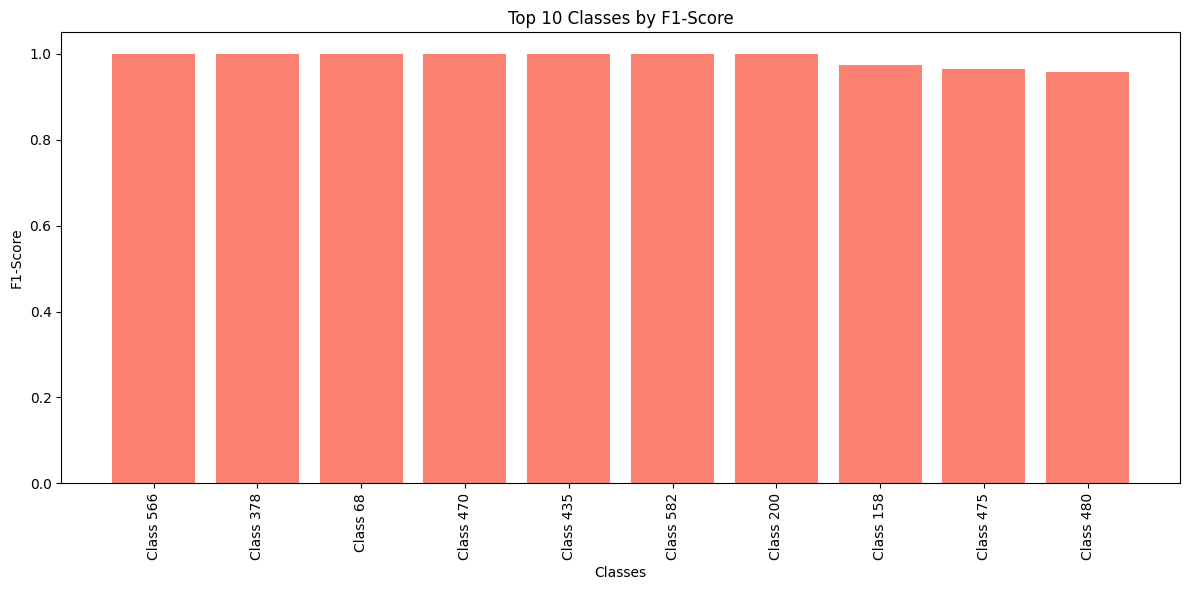

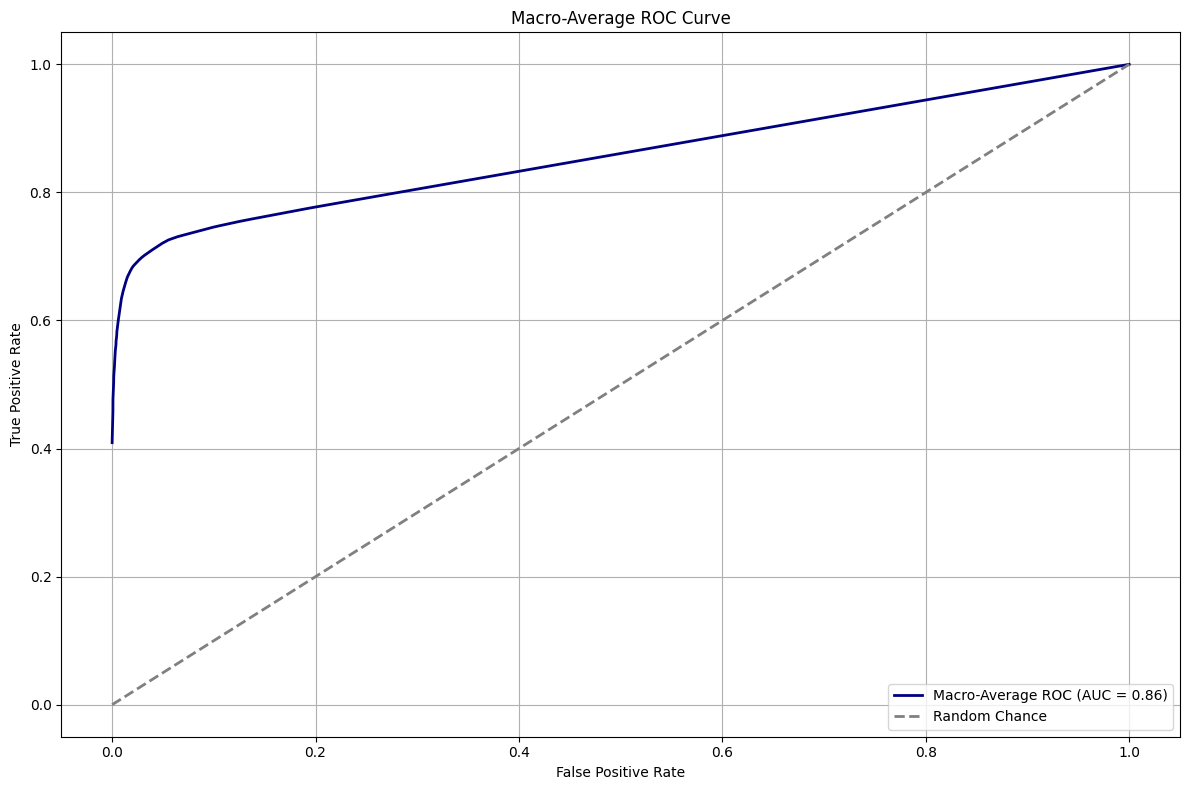

In [ ]:
# Align the labels between `y_test` and `y_pred`
unique_classes = np.union1d(y_test, y_pred)

# Metrics calculation
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, labels=unique_classes, zero_division=0
)

# Visualization
# 1. Accuracy Bar Plot
plt.figure(figsize=(6, 4))
plt.bar(['Accuracy'], [accuracy], color='skyblue')
plt.title('Accuracy Score')
plt.ylabel('Proportion')
plt.ylim(0, 1)
plt.show()

# Sort precision, recall, and F1-score in descending order and get top 10 indices
top_10_precision_idx = np.argsort(precision)[-10:][::-1]
top_10_recall_idx = np.argsort(recall)[-10:][::-1]
top_10_f1_idx = np.argsort(f1)[-10:][::-1]

# Precision and Recall (Top 10)
plt.figure(figsize=(12, 6))
top_10_classes = unique_classes[top_10_precision_idx]
x = np.arange(len(top_10_classes))
plt.bar(x - 0.2, precision[top_10_precision_idx], width=0.4, label='Precision', color='lightgreen')
plt.bar(x + 0.2, recall[top_10_precision_idx], width=0.4, label='Recall', color='lightblue')
plt.xticks(x, [f"Class {cls}" for cls in top_10_classes], rotation=90)
plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Top 10 Classes by Precision and Recall')
plt.legend()
plt.tight_layout()
plt.show()

# F1-Score (Top 10)
plt.figure(figsize=(12, 6))
top_10_classes_f1 = unique_classes[top_10_f1_idx]
plt.bar([f"Class {cls}" for cls in top_10_classes_f1], f1[top_10_f1_idx], color='salmon')
plt.xlabel('Classes')
plt.ylabel('F1-Score')
plt.title('Top 10 Classes by F1-Score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
from sklearn.metrics import roc_curve, auc

# Get the number of classes the model was trained on
trained_classes = rf.classes_
n_classes = len(trained_classes)

# Binarize y_test based on the model's trained classes
y_test_binarized = label_binarize(y_test, classes=trained_classes)

# Initialize dictionaries for FPR, TPR, and ROC AUC
fpr = {}
tpr = {}
roc_auc = {}

# Iterate over valid classes (only those present in y_test_binarized and predict_proba)
for i in range(y_test_binarized.shape[1]):
    try:
        if y_test_binarized[:, i].sum() > 0:  # Ensure the class has positive samples
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], rf.predict_proba(X_test)[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
    except IndexError:
        print(f"Skipping class {i} due to mismatched predictions or no positive samples.")

# Compute the macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in fpr]))
mean_tpr = np.zeros_like(all_fpr)

for i in fpr:
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= len(fpr)
macro_auc = auc(all_fpr, mean_tpr)

# Plot the macro-average ROC curve
plt.figure(figsize=(12, 8))
plt.plot(all_fpr, mean_tpr, color='navy', lw=2, label=f"Macro-Average ROC (AUC = {macro_auc:.2f})")
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=2, label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-Average ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

## XGBoost Model

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from scipy.sparse import hstack, csr_matrix
from sklearn.decomposition import TruncatedSVD
import numpy as np
from collections import Counter

# Downsample the DataFrame to reduce memory usage
police_data_downsampled = police_data.sample(frac=0.1, random_state=42)

# Define preprocessing function for offense descriptions using fuzzy matching
def reduce_unique_targets(offenses, threshold=80):
    from rapidfuzz import process, fuzz
    reduced_offenses = {}
    for offense in offenses:
        match = process.extractOne(offense, reduced_offenses.keys(), scorer=fuzz.token_sort_ratio)
        if match and match[1] >= threshold:
            reduced_offenses[match[0]].append(offense)
        else:
            reduced_offenses[offense] = [offense]
    return reduced_offenses

# Reduce unique targets
unique_offenses = police_data_downsampled['offensedescription'].unique()
reduced_offenses = reduce_unique_targets(unique_offenses)

def map_to_reduced_offense(offense, reduced_offenses):
    for key, values in reduced_offenses.items():
        if offense in values:
            return key
    return offense

police_data_downsampled['reduced_offensedescription'] = police_data_downsampled['offensedescription'].apply(
    lambda x: map_to_reduced_offense(x, reduced_offenses)
)

# Define categorical and numerical columns
categorical_cols = ['offensedescription', 'offensestarttime', 'offensestoptime', 'offensepremises']
numerical_cols = ['offense_hour', 'offense_month']

# Encode categorical columns
police_data_downsampled[categorical_cols] = police_data_downsampled[categorical_cols].astype(str)
encoder = OneHotEncoder(handle_unknown='ignore')
X_categorical = encoder.fit_transform(police_data_downsampled[categorical_cols])

# Combine numerical and categorical features
X_numerical = police_data_downsampled[numerical_cols].values
X = hstack([csr_matrix(X_numerical), X_categorical])

# Reduce dimensionality
svd = TruncatedSVD(n_components=100, random_state=42)
X = svd.fit_transform(X)

# Encode target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(police_data_downsampled['reduced_offensedescription'])

# Filter rare classes
class_counts = Counter(y)
min_samples = 5
valid_classes = [cls for cls, count in class_counts.items() if count >= min_samples]
mask = np.isin(y, valid_classes)
X = X[mask]
y = y[mask]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Re-map classes to consecutive integers
unique_classes = np.unique(y_train)
class_mapping = {old: new for new, old in enumerate(unique_classes)}
y_train = np.array([class_mapping[label] for label in y_train])
y_test = np.array([class_mapping[label] for label in y_test if label in class_mapping])

# Train XGBoost
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss'  # Removed 'use_label_encoder'
)
xgb.fit(X_train, y_train)

# Predictions
y_pred = xgb.predict(X_test)

# Reverse map predictions to original class labels
reverse_mapping = {v: k for k, v in class_mapping.items()}
y_test_original = np.array([reverse_mapping[label] for label in y_test])
y_pred_original = np.array([reverse_mapping[label] for label in y_pred])

# Evaluate the model
print("Accuracy:", accuracy_score(y_test_original, y_pred_original))
print("Classification Report:")
#print(classification_report(y_test_original, y_pred_original, labels=np.unique(y_test_original), zero_division=0))

# Generate the classification report as a dictionary
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

# Convert the report to a DataFrame for better manipulation
report_df = pd.DataFrame(report_dict).transpose()

# Sort by 'support' column to get the top 10 classes
top_10_report = report_df.sort_values(by='support', ascending=False).head(10)

# Display the top 10 classes' classification report
print(top_10_report)

Accuracy: 0.8064243448858833
Classification Report:
              precision    recall  f1-score  support
weighted avg   0.807375  0.806424  0.800877   1183.0
macro avg      0.492824  0.501111  0.484585   1183.0
49             0.889831  0.945946  0.917031    111.0
32             1.000000  1.000000  1.000000     83.0
122            1.000000  1.000000  1.000000     70.0
18             0.946429  0.868852  0.905983     61.0
139            1.000000  1.000000  1.000000     59.0
27             0.897436  0.777778  0.833333     45.0
43             0.860465  0.880952  0.870588     42.0
61             1.000000  0.975000  0.987342     40.0


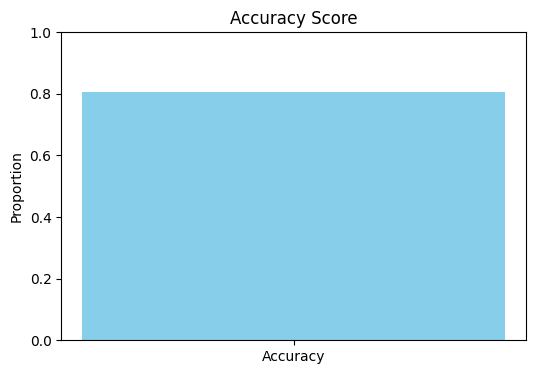

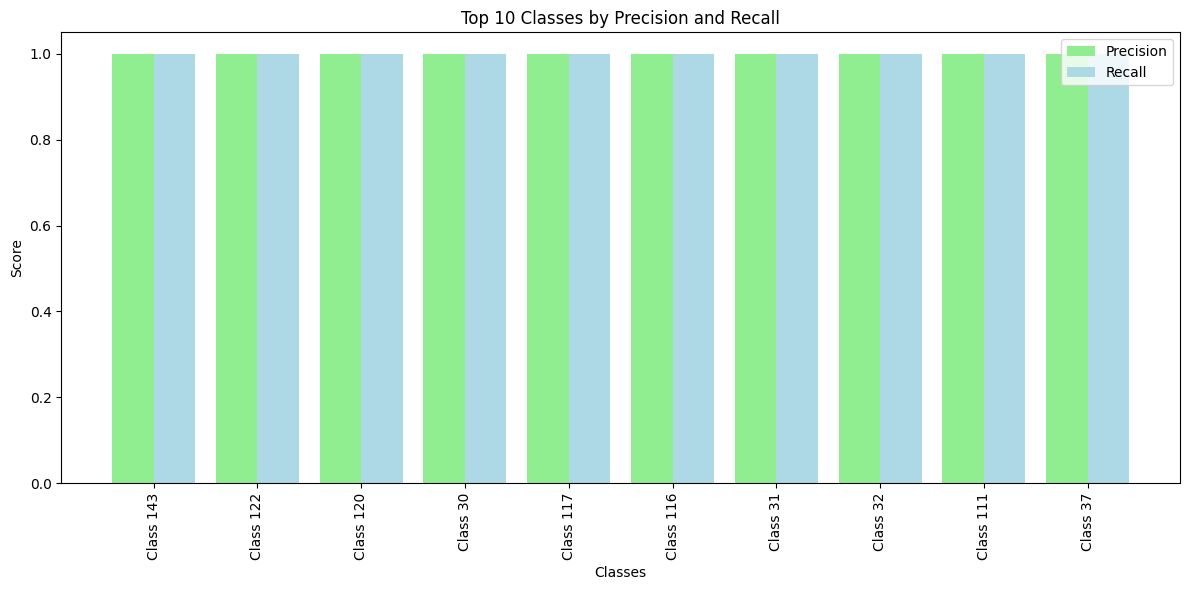

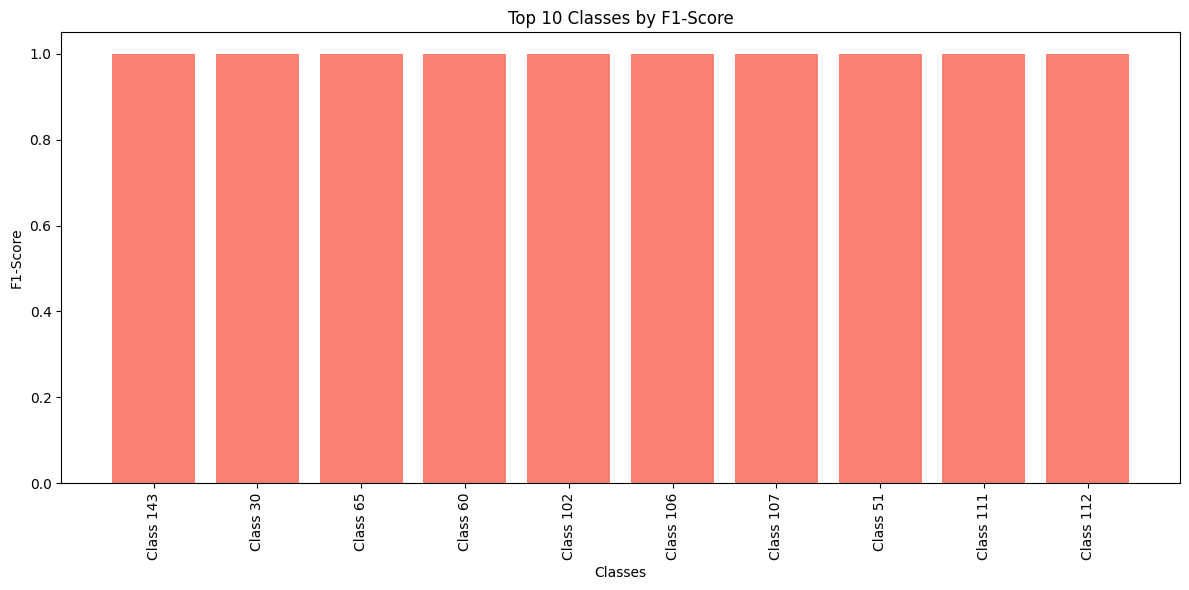

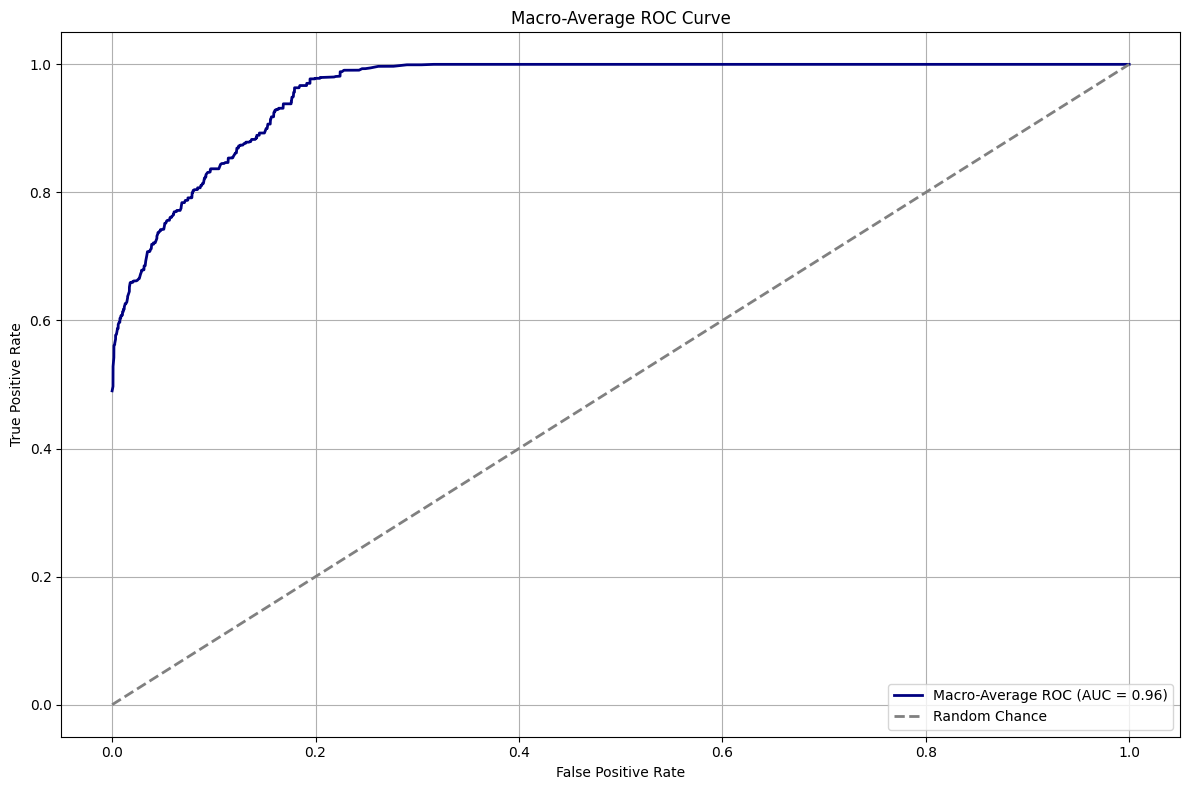

In [26]:
# Align the labels between `y_test` and `y_pred`
unique_classes = np.union1d(y_test, y_pred)

# Metrics calculation
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, labels=unique_classes, zero_division=0
)

# Visualization
# 1. Accuracy Bar Plot
plt.figure(figsize=(6, 4))
plt.bar(['Accuracy'], [accuracy], color='skyblue')
plt.title('Accuracy Score')
plt.ylabel('Proportion')
plt.ylim(0, 1)
plt.show()

# Sort precision, recall, and F1-score in descending order and get top 10 indices
top_10_precision_idx = np.argsort(precision)[-10:][::-1]
top_10_recall_idx = np.argsort(recall)[-10:][::-1]
top_10_f1_idx = np.argsort(f1)[-10:][::-1]

# Precision and Recall (Top 10)
plt.figure(figsize=(12, 6))
top_10_classes = unique_classes[top_10_precision_idx]
x = np.arange(len(top_10_classes))
plt.bar(x - 0.2, precision[top_10_precision_idx], width=0.4, label='Precision', color='lightgreen')
plt.bar(x + 0.2, recall[top_10_precision_idx], width=0.4, label='Recall', color='lightblue')
plt.xticks(x, [f"Class {cls}" for cls in top_10_classes], rotation=90)
plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Top 10 Classes by Precision and Recall')
plt.legend()
plt.tight_layout()
plt.show()

# F1-Score (Top 10)
plt.figure(figsize=(12, 6))
top_10_classes_f1 = unique_classes[top_10_f1_idx]
plt.bar([f"Class {cls}" for cls in top_10_classes_f1], f1[top_10_f1_idx], color='salmon')
plt.xlabel('Classes')
plt.ylabel('F1-Score')
plt.title('Top 10 Classes by F1-Score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
from sklearn.metrics import roc_curve, auc

# Get the number of classes the model was trained on
trained_classes = xgb.classes_
n_classes = len(trained_classes)

# Binarize y_test based on the model's trained classes
y_test_binarized = label_binarize(y_test, classes=trained_classes)

# Initialize dictionaries for FPR, TPR, and ROC AUC
fpr = {}
tpr = {}
roc_auc = {}

# Iterate over valid classes (only those present in y_test_binarized and predict_proba)
for i in range(y_test_binarized.shape[1]):
    try:
        if y_test_binarized[:, i].sum() > 0:  # Ensure the class has positive samples
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], xgb.predict_proba(X_test)[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
    except IndexError:
        print(f"Skipping class {i} due to mismatched predictions or no positive samples.")

# Compute the macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in fpr]))
mean_tpr = np.zeros_like(all_fpr)

for i in fpr:
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= len(fpr)
macro_auc = auc(all_fpr, mean_tpr)

# Plot the macro-average ROC curve
plt.figure(figsize=(12, 8))
plt.plot(all_fpr, mean_tpr, color='navy', lw=2, label=f"Macro-Average ROC (AUC = {macro_auc:.2f})")
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=2, label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-Average ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

## Best Model (offensedescription)

In [ ]:
# Downsample the DataFrame to reduce memory usage
police_data_downsampled = police_data.sample(frac=0.1, random_state=42)

# Get unique values in 'offensedescription'
unique_offenses = police_data_downsampled['offensedescription'].unique()

# Define a function to perform fuzzy matching and reduce unique targets
def reduce_unique_targets(offenses, threshold=80):
    reduced_offenses = {}
    for offense in offenses:
        match = process.extractOne(offense, reduced_offenses.keys(), scorer=fuzz.token_sort_ratio)
        if match and match[1] >= threshold:
            reduced_offenses[match[0]].append(offense)
        else:
            reduced_offenses[offense] = [offense]
    return reduced_offenses

# Reduce unique targets in 'offensedescription'
reduced_offenses = reduce_unique_targets(unique_offenses)

# Map original offenses to reduced offenses
def map_to_reduced_offense(offense, reduced_offenses):
    for key, values in reduced_offenses.items():
        if offense in values:
            return key
    return offense

police_data_downsampled['reduced_offensedescription'] = police_data_downsampled['offensedescription'].apply(
    lambda x: map_to_reduced_offense(x, reduced_offenses)
)

# Define the correct categorical and numerical columns
categorical_cols = [
    'AgencyORI', 'AgencyName', 'offenseservicenumber', 'offensedescription',
    'offensestarttime', 'offensestoptime', 'offensetimedispatched',
    'offensebeat', 'offensewatch', 'offensesignal1', 'offensename',
    'offenserace', 'offensegender', 'offenseage', 'offenseblock',
    'offensedirection', 'offensestreet', 'offenseapartment', 'offensecity',
    'offensestate', 'offensepremises', 'offensedateofoccurence1',
    'offensetimeofoccurence1', 'offensedateofoccurence2',
    'offensetimeofoccurence2', 'offenseucr1', 'offensemethodofoffense',
    'offensefamilyviolence', 'offensegangacitivty',
    'offensereportofficerbadge1', 'offensereportingofficerbadge2',
    'offenserecorddate', 'offensestatus', 'offense_day_of_week'
]

numerical_cols = [
    'offensereportingarea', 'offensezip', 'offensepropertyattackcode',
    'offense_month', 'offense_hour'
]

# Ensure all categorical columns are strings
police_data_downsampled[categorical_cols] = police_data_downsampled[categorical_cols].astype(str)

# One-hot encode categorical columns
encoder = OneHotEncoder()
X_categorical = encoder.fit_transform(police_data_downsampled[categorical_cols])

# Combine numerical and encoded categorical features
X_numerical = police_data_downsampled[numerical_cols].values
X = hstack([X_numerical, X_categorical])

# Convert sparse matrix to CSR format for slicing
X = csr_matrix(X)

# Encode the target variable with reduced offenses
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(police_data_downsampled['reduced_offensedescription'])

# Remove rare classes
class_counts = Counter(y)
min_samples = 5  # Minimum number of samples for a class to be retained
valid_classes = [cls for cls, count in class_counts.items() if count >= min_samples]

# Filter the dataset to retain only valid classes
mask = [label in valid_classes for label in y]
X = X[mask]
y = y[mask]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance using RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

# Feature selection using Random Forest
feature_selector = RandomForestClassifier(n_estimators=50, random_state=42)
feature_selector.fit(X_train, y_train)
selector = SelectFromModel(feature_selector, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_selected, y_train)

# Train the best Random Forest model
best_rf = grid_search.best_estimator_
best_rf.fit(X_train_selected, y_train)

# Make predictions
y_pred = best_rf.predict(X_test_selected)

# Evaluate the model
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.8588334742180896
Classification Report:
              precision    recall  f1-score   support

           7       1.00      0.80      0.89         5
          13       1.00      1.00      1.00         7
          17       0.80      0.97      0.88        29
          19       1.00      1.00      1.00         1
          22       0.00      0.00      0.00         1
          26       0.67      0.60      0.63        10
          35       0.00      0.00      0.00         3
          36       0.50      0.40      0.44         5
          40       0.00      0.00      0.00         3
          43       0.00      0.00      0.00         1
          47       0.80      0.92      0.86        13
          53       0.00      0.00      0.00         2
          54       0.00      0.00      0.00         1
          60       0.00      0.00      0.00         2
          64       0.67      0.4

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


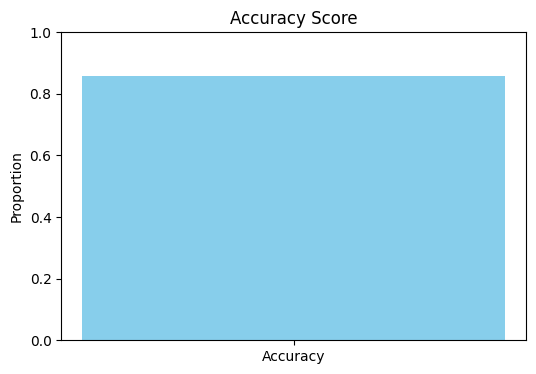

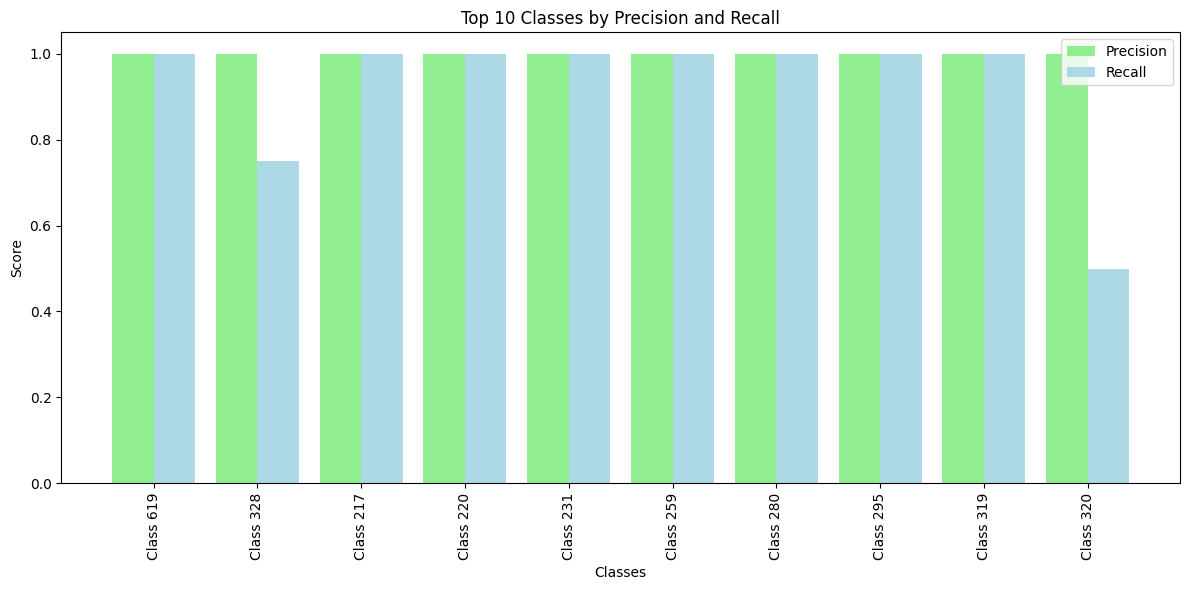

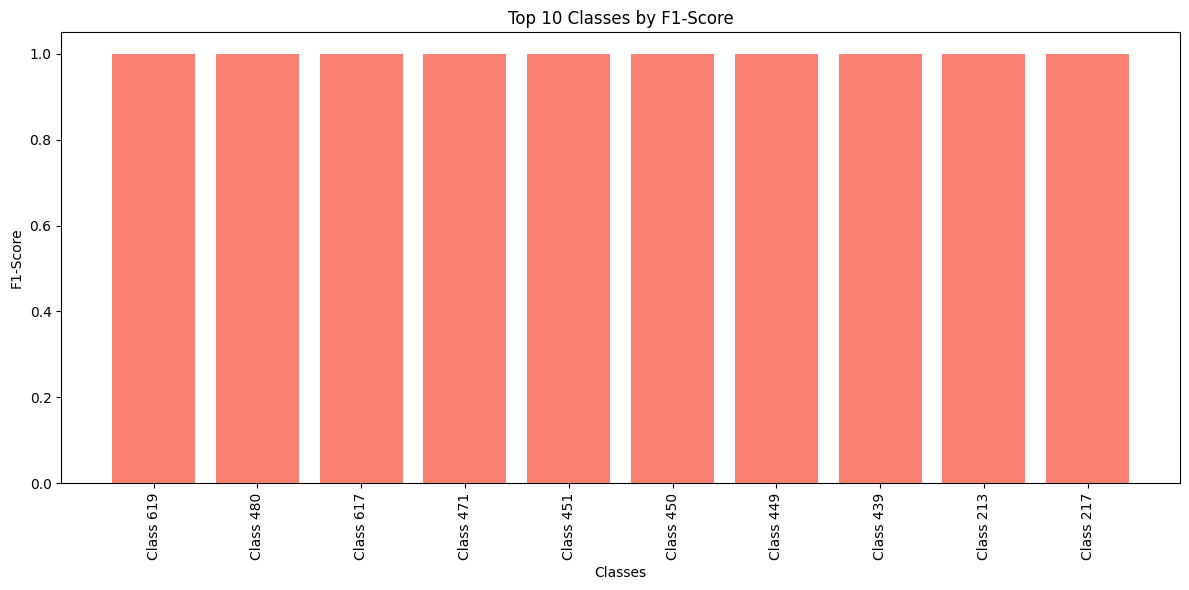

In [ ]:
# Graphs
# 1. Accuracy
plt.figure(figsize=(6, 4))
plt.bar(['Accuracy'], [accuracy], color='skyblue')
plt.title('Accuracy Score')
plt.ylabel('Proportion')
plt.ylim(0, 1)
plt.show()

# 2. Precision and Recall (Top 10 Classes)
top_10_precision_idx = np.argsort(precision)[-10:][::-1]
plt.figure(figsize=(12, 6))
x = np.arange(len(top_10_precision_idx))
plt.bar(x - 0.2, precision[top_10_precision_idx], width=0.4, label='Precision', color='lightgreen')
plt.bar(x + 0.2, recall[top_10_precision_idx], width=0.4, label='Recall', color='lightblue')
plt.xticks(x, [f"Class {cls}" for cls in unique_classes[top_10_precision_idx]], rotation=90)
plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Top 10 Classes by Precision and Recall')
plt.legend()
plt.tight_layout()
plt.show()

# 3. F1-Score (Top 10 Classes)
top_10_f1_idx = np.argsort(f1)[-10:][::-1]
plt.figure(figsize=(12, 6))
plt.bar(
    [f"Class {cls}" for cls in unique_classes[top_10_f1_idx]],
    f1[top_10_f1_idx],
    color='salmon'
)
plt.xlabel('Classes')
plt.ylabel('F1-Score')
plt.title('Top 10 Classes by F1-Score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
